### Importing all the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

In [2]:
from causalml.inference.meta import XGBTRegressor

In [3]:
from causalml.inference.meta import LRSRegressor
from sklearn.linear_model import LinearRegression

In [4]:
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import random

### Setting Data and other variables for Causal ML

In [5]:
df = pd.read_csv("ToyotaCorolla.csv")

In [6]:
#Encoding for categorical variables
df = pd.get_dummies(df, columns = ['FuelType'])

In [7]:
df.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType_CNG,FuelType_Diesel,FuelType_Petrol
0,13500,23,46986,90,1,0,2000,3,1165,0,1,0
1,13750,23,72937,90,1,0,2000,3,1165,0,1,0
2,13950,24,41711,90,1,0,2000,3,1165,0,1,0
3,14950,26,48000,90,0,0,2000,3,1165,0,1,0
4,13750,30,38500,90,0,0,2000,3,1170,0,1,0


In [8]:
#Creating a list for propensity score (probability of receiving treatment over control given the conditions) using random library
e_list = []
for i in range(len(df)):
    e_list.append(random.random())

e = np.array(e_list)

In [9]:
#setting outcome variable
y = df['Price']

#setting independent feature variables
X = df.drop(axis=1, columns=['Price'])

#setting feature - 'Automatic'(a binary column) as treatment flag
w = df['Automatic']

In [10]:
#Based on binary values set in w as above, value = 1 will be treatment set, value =0 will be control set
w_multi = np.array(['treatment' if x==1 else 'control' for x in w])

In [11]:
e_multi = {'treatment': e}

In [12]:
#Setting feature names from the selected dataset
feature_names = X.columns
print(feature_names)

Index(['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight',
       'FuelType_CNG', 'FuelType_Diesel', 'FuelType_Petrol'],
      dtype='object')


## Using LRSRegressor()

In [13]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, w, y)
print('Average Treatment Effect (LR): {:.2f} \n(Lower Bound: {:.2f}, Upper Bound: {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (LR): 165.13 
(Lower Bound: -62.91, Upper Bound: 393.16)


In [14]:
#Treatment effect predictions
lrs_tau = lr.fit_predict(X, w, y)
lrs_tau

array([[165.12547004],
       [165.12547004],
       [165.12547004],
       ...,
       [165.12547004],
       [165.12547004],
       [165.12547004]])

In [15]:
model_tau = LinearRegression()

##### Method = Auto
- calculates importance based on default implementation

In [16]:
lr_auto_features = lr.get_importance(X=X, tau=lrs_tau, normalize=True, method='auto', features=feature_names)
lr_auto_features

{1: Age                0.98995
 KM                 0.01005
 HP                 0.00000
 MetColor           0.00000
 Automatic          0.00000
 CC                 0.00000
 Doors              0.00000
 Weight             0.00000
 FuelType_CNG       0.00000
 FuelType_Diesel    0.00000
 FuelType_Petrol    0.00000
 dtype: float64}

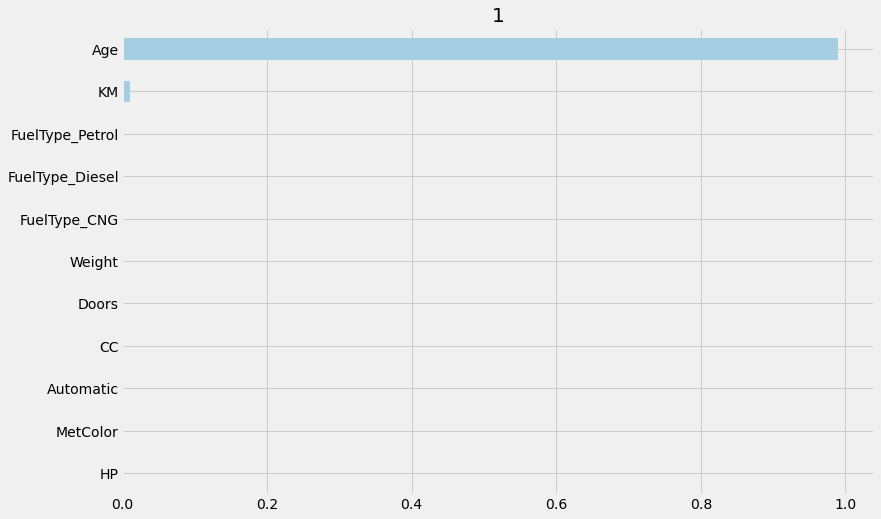

In [17]:
#Plotting above feature importance result
lr.plot_importance(X=X, tau=lrs_tau, normalize=True, method='auto', features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [18]:
start_time = time.time()

lr_perm_features = lr.get_importance(X=X, tau=lrs_tau, method='permutation', features=feature_names, random_state=42)

print(lr_perm_features)
print("Elapsed time: %s seconds" % (time.time() - start_time))

{1: Age                0.0
KM                 0.0
HP                 0.0
MetColor           0.0
Automatic          0.0
CC                 0.0
Doors              0.0
Weight             0.0
FuelType_CNG       0.0
FuelType_Diesel    0.0
FuelType_Petrol    0.0
dtype: float64}
Elapsed time: 0.04876279830932617 seconds


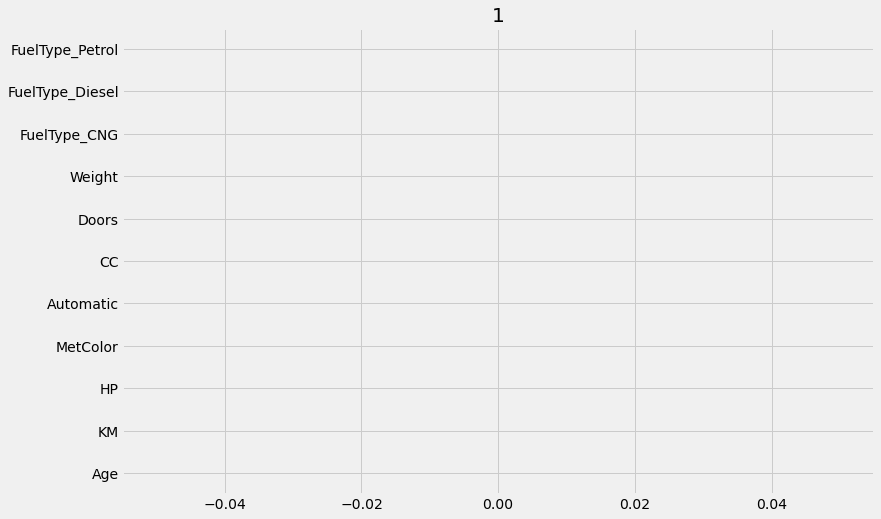

In [19]:
#Plotting above feature importance result
lr.plot_importance(X=X, tau=lrs_tau, normalize=True, method='permutation', features=feature_names)

### Permutation Importance (sklearn)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, lrs_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [21]:
start_time = time.time()

perm_imp_test = permutation_importance(estimator=model_tau_fit, X=X_test, y=y_test, random_state=42).importances_mean

pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.10404205322265625 seconds


In [22]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

FuelType_Diesel    0.088600
Age                0.019875
CC                 0.018811
FuelType_Petrol    0.011445
HP                 0.008251
Weight             0.006664
FuelType_CNG       0.005061
Doors             -0.001801
KM                -0.004394
MetColor          -0.004855
Automatic         -0.007104
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

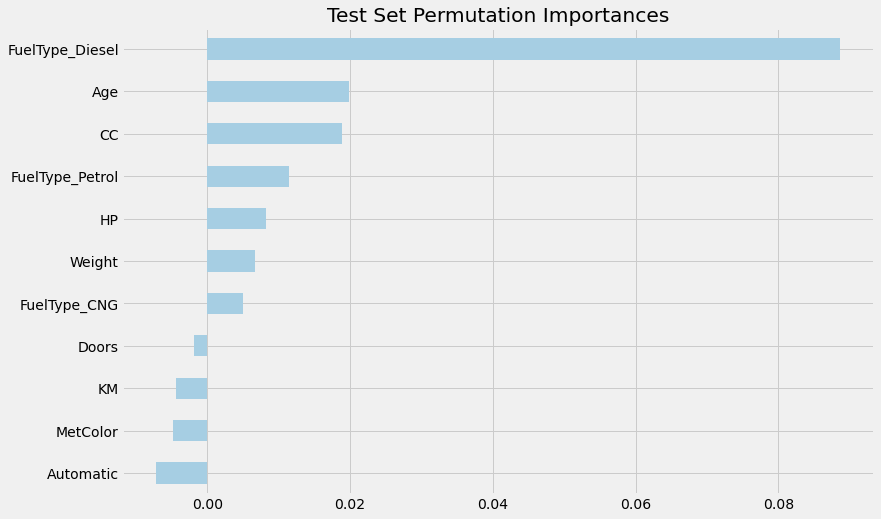

In [23]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

#### Training Set

In [24]:
perm_imp_train = permutation_importance(estimator=model_tau_fit, X=X_train, y=y_train, random_state=42).importances_mean

pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

FuelType_Diesel    0.061301
CC                 0.048522
HP                 0.025701
KM                 0.006462
FuelType_CNG       0.004914
Age                0.004829
Automatic          0.004827
Weight             0.002700
FuelType_Petrol    0.002618
MetColor           0.002426
Doors              0.002251
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

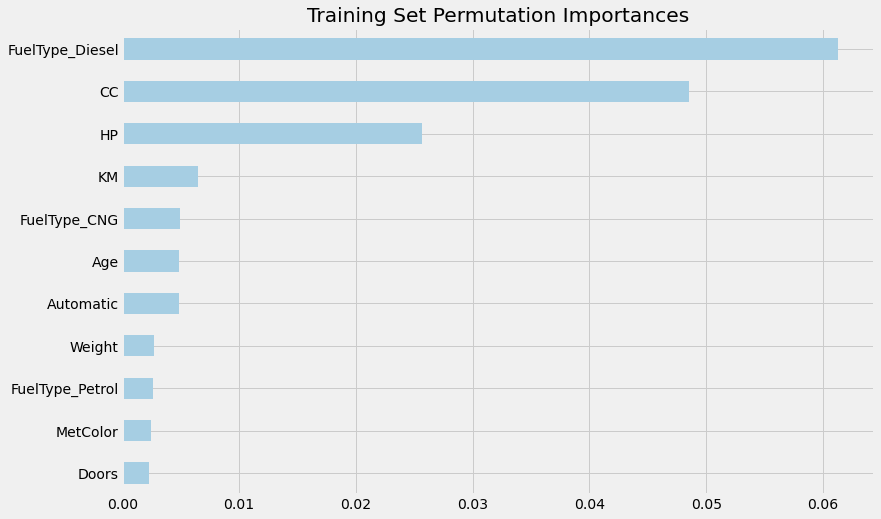

In [25]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [26]:
shap_lrs = lr.get_shap_values(X=X, tau=lrs_tau)
shap_lrs

{1: array([[5.55111512e-16, 2.77555756e-17, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.55111512e-16, 2.77555756e-17, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.55111512e-16, 2.77555756e-17, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [5.55111512e-16, 2.77555756e-17, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.55111512e-16, 2.77555756e-17, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.77635684e-15, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])}

In [27]:
np.mean(np.abs(shap_lrs[1]),axis=0)

array([6.17039691e-16, 2.73690077e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

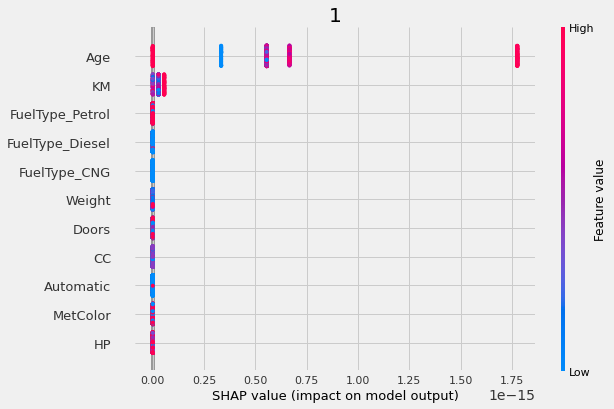

In [28]:
# Plot shap values without specifying shap_dict
lr.plot_shap_values(X=X, tau=lrs_tau, features=feature_names)

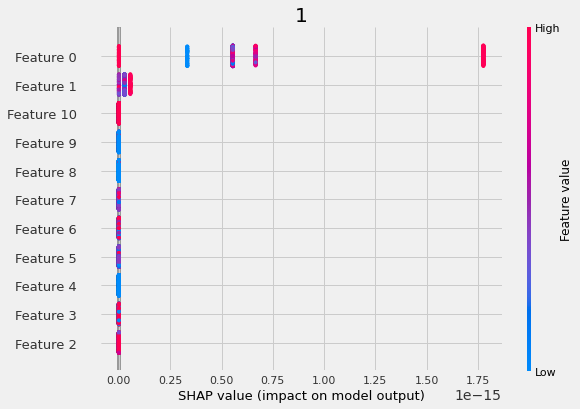

In [29]:
# Plot shap values WITH specifying shap_dict
lr.plot_shap_values(X=X, shap_dict=shap_lrs)

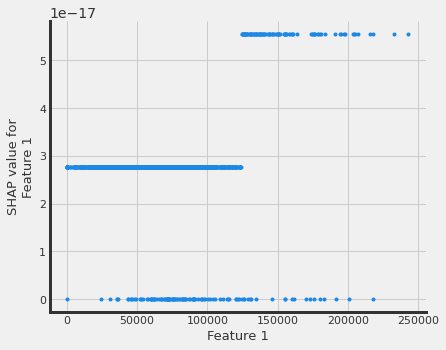

In [30]:
# interaction_idx set to None (no color coding for interaction effects)
lr.plot_shap_dependence(treatment_group=1,
                              feature_idx=1,
                              X=X,
                              tau=lrs_tau,
                              interaction_idx=None,
                              shap_dict=shap_lrs)

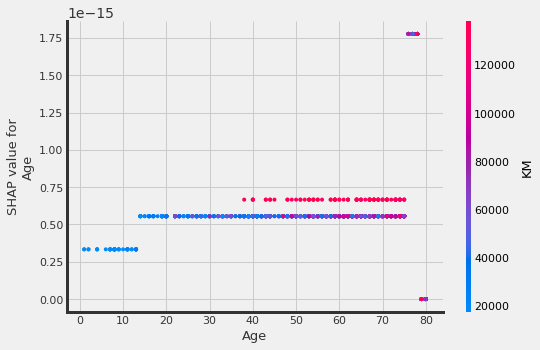

In [31]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
lr.plot_shap_dependence(treatment_group=1,
                              feature_idx='Age',
                              X=X,
                              tau=lrs_tau,
                              interaction_idx='auto',
                              shap_dict=shap_lrs,
                              features=feature_names)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


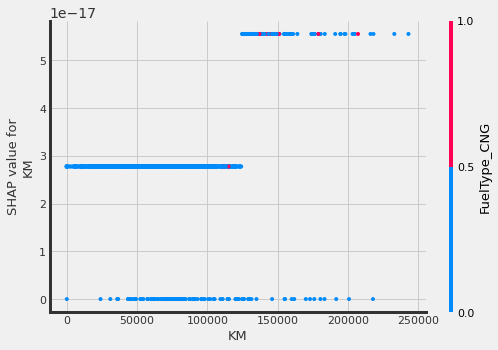

In [32]:
# interaction_idx set to specific index
lr.plot_shap_dependence(treatment_group=1,
                              feature_idx=1,
                              X=X,
                              tau=lrs_tau,
                              interaction_idx=8,
                              shap_dict=shap_lrs, 
                              features=feature_names)

## XGBTRegressor

In [33]:
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, w, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (XGBoost): 416.03 (337.22, 494.85)


In [34]:
xg_tau = xg.fit_predict(X, w, y)
xg_tau

array([[3821.03515625],
       [3520.18359375],
       [2297.92089844],
       ...,
       [1411.203125  ],
       [2542.2265625 ],
       [3478.98828125]])

In [35]:
model_tau = XGBRegressor(importance_type='gain')

##### Method = Auto
- calculates importance based on default implementation

In [36]:
xg_auto_features = xg.get_importance(X=X, tau=xg_tau, normalize=True, method='auto', features=feature_names)
xg_auto_features

{1: Age                0.309918
 KM                 0.227939
 HP                 0.219012
 Weight             0.178054
 Doors              0.023968
 CC                 0.020967
 MetColor           0.012106
 FuelType_Petrol    0.007675
 Automatic          0.000362
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

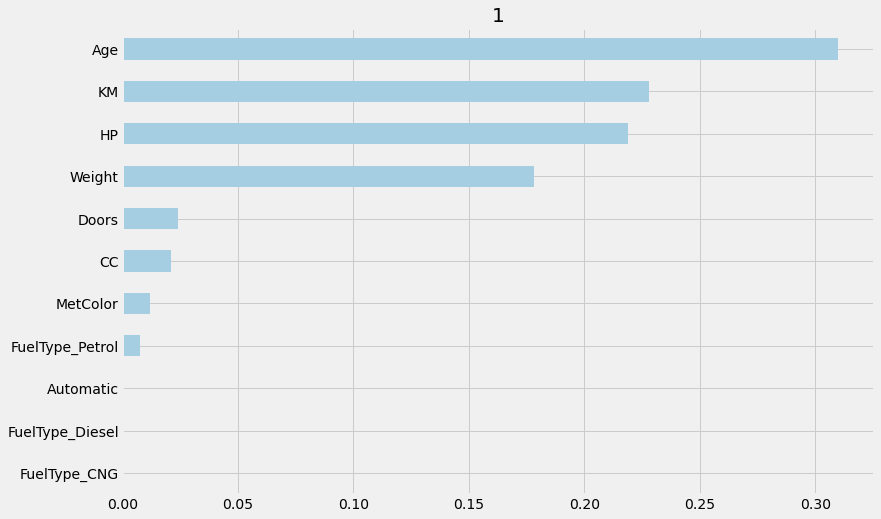

In [37]:
#Plotting above feature importance result
xg.plot_importance(X=X, tau=xg_tau, normalize=True, method='auto', features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [38]:
start_time = time.time()

xg_perm_features = xg.get_importance(X=X, tau=xg_tau, method='permutation', features=feature_names, random_state=42)

print(xg_perm_features)
print("Elapsed time: %s seconds" % (time.time() - start_time))

{1: Age                0.600937
Weight             0.462695
KM                 0.278788
HP                 0.176682
FuelType_Petrol    0.030534
Doors              0.020778
CC                 0.016202
MetColor           0.006808
FuelType_CNG       0.000000
FuelType_Diesel    0.000000
Automatic         -0.000378
dtype: float64}
Elapsed time: 0.2021322250366211 seconds


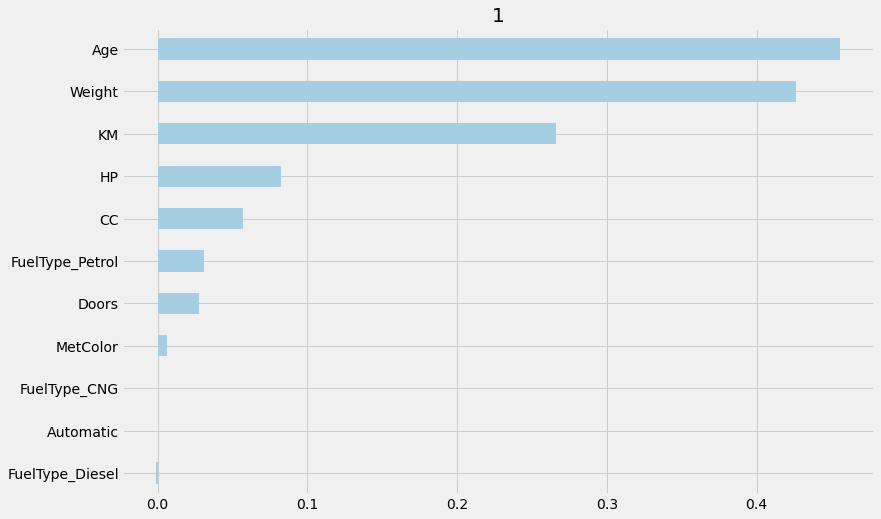

In [39]:
#Plotting above feature importance result
xg.plot_importance(X=X, tau=xg_tau, normalize=True, method='permutation', features=feature_names)

### Permutation Importance (sklearn)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, xg_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [41]:
start_time = time.time()

perm_imp_test = permutation_importance(estimator=model_tau_fit, X=X_test, y=y_test, random_state=42).importances_mean

pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.30614256858825684 seconds


In [42]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Age                0.819075
KM                 0.310118
HP                 0.284848
Weight             0.228907
CC                 0.051432
Doors              0.021376
FuelType_Petrol    0.014331
MetColor           0.004400
FuelType_CNG       0.001681
Automatic          0.000152
FuelType_Diesel    0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

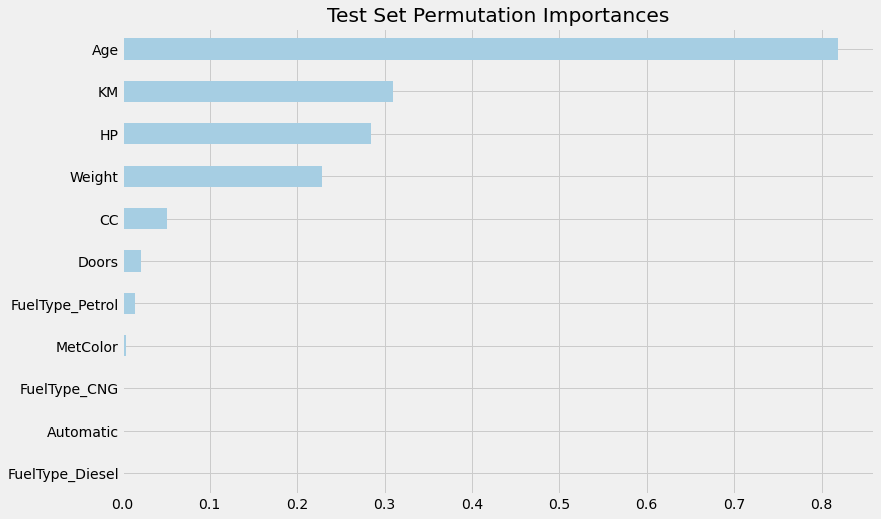

In [43]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

#### Training Set

In [44]:
perm_imp_train = permutation_importance(estimator=model_tau_fit, X=X_train, y=y_train, random_state=42).importances_mean

pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

Age                1.048681
KM                 0.631836
Weight             0.318634
HP                 0.286793
CC                 0.087466
Doors              0.054564
MetColor           0.042695
FuelType_Petrol    0.020487
FuelType_CNG       0.005032
Automatic          0.001405
FuelType_Diesel    0.000000
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

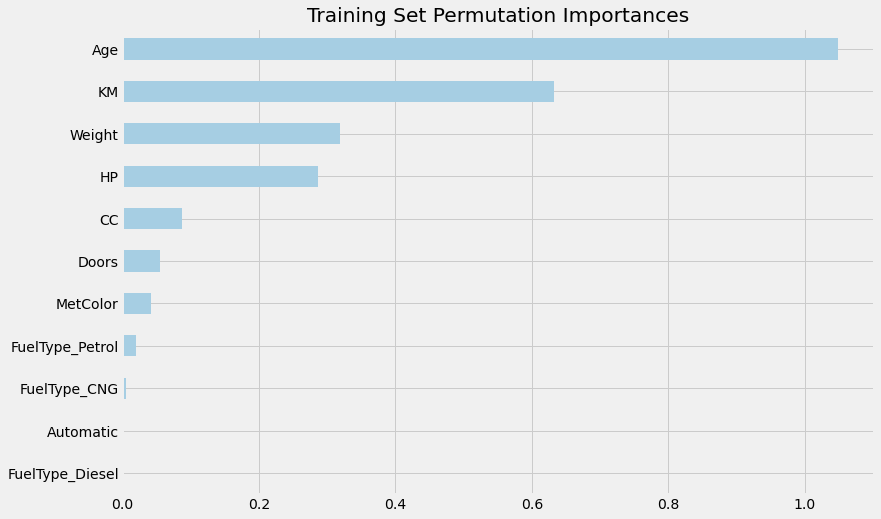

In [45]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [46]:
shap_xg = xg.get_shap_values(X=X, tau=xg_tau)
shap_xg

{1: array([[2122.64394124,   11.1368951 ,  555.53750398, ...,    0.        ,
            0.        , -139.50387882],
        [1950.01774098,  245.62642826,  538.71697137, ...,    0.        ,
            0.        , -199.10609186],
        [1509.49319521,   11.06719457,  548.40408713, ...,    0.        ,
            0.        , -148.57026039],
        ...,
        [-137.86959012,  637.14196749,  287.61497734, ...,    0.        ,
            0.        ,   16.42911521],
        [-118.67537352,  755.27891071,  310.92460994, ...,    0.        ,
            0.        ,   18.48072412],
        [-110.96350936,  895.03128322,  -87.34530775, ...,    0.        ,
            0.        ,   19.57225172]])}

In [47]:
np.mean(np.abs(shap_xg[1]),axis=0)

array([490.31208638, 355.4853318 , 232.34703905,  52.48501349,
         5.83205376,  57.95243883,  57.39153479, 232.28616635,
         0.        ,   0.        ,  55.40464712])

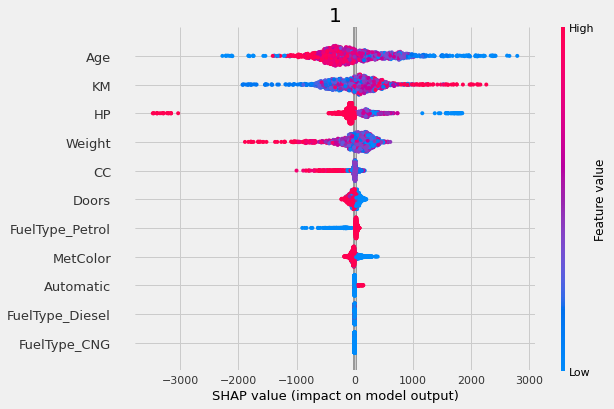

In [48]:
# Plot shap values without specifying shap_dict
xg.plot_shap_values(X=X, tau=xg_tau, features=feature_names)

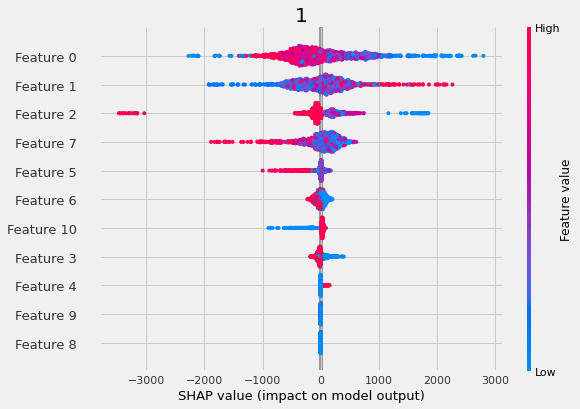

In [49]:
# Plot shap values WITH specifying shap_dict
xg.plot_shap_values(X=X, shap_dict=shap_xg)

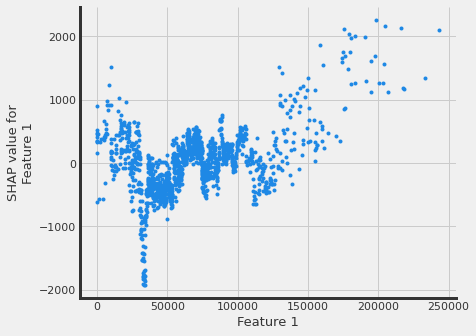

In [50]:
# interaction_idx set to None (no color coding for interaction effects)
xg.plot_shap_dependence(treatment_group=1,
                              feature_idx=1,
                              X=X,
                              tau=xg_tau,
                              interaction_idx=None,
                              shap_dict=shap_xg)

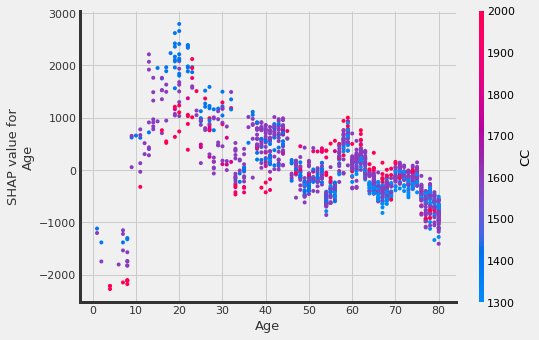

In [51]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
xg.plot_shap_dependence(treatment_group=1,
                              feature_idx='Age',
                              X=X,
                              tau=xg_tau,
                              interaction_idx='auto',
                              shap_dict=shap_xg,
                              features=feature_names)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


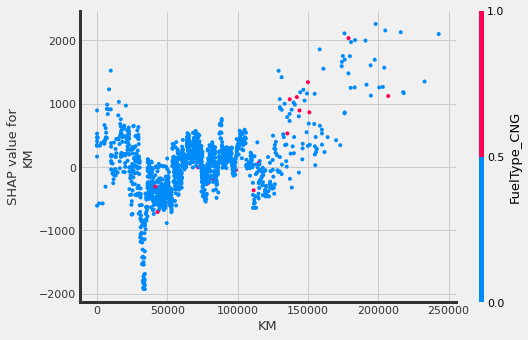

In [52]:
# interaction_idx set to specific index
xg.plot_shap_dependence(treatment_group=1,
                              feature_idx=1,
                              X=X,
                              tau=xg_tau,
                              interaction_idx=8,
                              shap_dict=shap_xg, 
                              features=feature_names)

## Conclusion

### 1. Based on Feature Importance

In [53]:
lr_auto_features

{1: Age                0.98995
 KM                 0.01005
 HP                 0.00000
 MetColor           0.00000
 Automatic          0.00000
 CC                 0.00000
 Doors              0.00000
 Weight             0.00000
 FuelType_CNG       0.00000
 FuelType_Diesel    0.00000
 FuelType_Petrol    0.00000
 dtype: float64}

In [54]:
lr_perm_features

{1: Age                0.0
 KM                 0.0
 HP                 0.0
 MetColor           0.0
 Automatic          0.0
 CC                 0.0
 Doors              0.0
 Weight             0.0
 FuelType_CNG       0.0
 FuelType_Diesel    0.0
 FuelType_Petrol    0.0
 dtype: float64}

In [55]:
xg_auto_features

{1: Age                0.309918
 KM                 0.227939
 HP                 0.219012
 Weight             0.178054
 Doors              0.023968
 CC                 0.020967
 MetColor           0.012106
 FuelType_Petrol    0.007675
 Automatic          0.000362
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

In [56]:
xg_perm_features

{1: Age                0.600937
 Weight             0.462695
 KM                 0.278788
 HP                 0.176682
 FuelType_Petrol    0.030534
 Doors              0.020778
 CC                 0.016202
 MetColor           0.006808
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 Automatic         -0.000378
 dtype: float64}

- LRS
    - Auto Method gives Age highest importance and a very slight importance to KM.
    - Permutation gives no feature any importance.
- XGBT
    - Auto Method gives Age highest importance followed by KM, HP, Weight.
    - Permutation Method too gives higher importance to Age of vehicle for determing its Price followed by Weight, KM, HP.

### 2. Based on Permutation Importance

- LRS
    - LRS doesn't place high values on features on permuting. However, highest score is around Fuel Type, suggesting it could have some influence on outcome variable on permuting or making changes to those values.
- XGBT
    - Permutation importance places similar importance as feature importance, giving Age has highest importance in both training and test set.
    - Age is then followed by KM.
    - The difference between training and test set is that test set prioritized HP over Weight, whereas it's vice versa for training set.
    - These suggest that permuting above variables shows difference in outcome variable - Price.

### 3. Based on Shapley plots

- LRS
    - Shapley values array or plots doesn't seem to place importance to any specific feature.
- XGBT
    - We can see clusters around Age, KM, HP and Weight suggesting that changing or modifying these columns would have influence on outcome variable i.e. Price.
    - Small clusters can be seen around Doors as well, which could have some influence on Price as well.

In conclusion, for LRS, it's difficult to put importance on multiple features. However, for XGBT, we can say that different methods more or less put importance on similar features i.e. Age, KM, HP and Weight to determine the outcome variable - Price.